In [1]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import pickle
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import random
# import copulae
# from copulae import EmpiricalCopula, pseudo_obs
# from copulae.datasets import load_marginal_data
import yfinance as yf
from yahoofinancials import YahooFinancials
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.api import VAR
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest, f_regression
import branca
from scipy.interpolate import griddata
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib.collections import PatchCollection
import seaborn as sns
import tslearn

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [2]:

xls1 = pd.read_excel("f01hist.xls", sheet_name="Data", header=2)
xls1 = xls1.drop(xls1.index[0:8], axis=0)
xls1["Description"] = pd.to_datetime(xls1["Description"])
xls1["Description"] = xls1["Description"].dt.date.apply(lambda x: x.strftime("%Y-%m"))

xls3 = pd.read_excel("f11hist-1969-2009.xls", sheet_name="Data", header=2)
xls3 = xls3.drop(xls3.index[0:8], axis=0)
xls3["Description"] = pd.to_datetime(xls3["Description"])
xls3["Description"] = xls3["Description"].dt.date.apply(lambda x: x.strftime("%Y-%m"))

xls4 = pd.read_excel("f11hist.xls", sheet_name="Data", header=2)
xls4 = xls4.drop(xls4.index[0:8], axis=0)
xls4["Description"] = pd.to_datetime(xls4["Description"])
xls4["Description"] = xls4["Description"].dt.date.apply(lambda x: x.strftime("%Y-%m"))

xls34 = pd.concat([xls3, xls4], axis=0)

xls5 = pd.read_excel("g01hist.xls", sheet_name="Data", header=2)
xls5 = xls5.drop(xls5.index[0:8], axis=0)
xls5["Description"] = pd.to_datetime(xls5["Description"])
xls5["Description"] = xls5["Description"].dt.date.apply(lambda x: x.strftime("%Y-%m"))

xls6 = pd.read_excel("h01hist.xls", sheet_name="Data", header=2)
xls6 = xls6.drop(xls6.index[0:8], axis=0)
xls6["Description"] = pd.to_datetime(xls6["Description"])
xls6["Description"] = xls6["Description"].dt.date.apply(lambda x: x.strftime("%Y-%m"))

xls7 = pd.read_excel("h03hist.xls", sheet_name="Data", header=2)
xls7 = xls7.drop(xls7.index[0:8], axis=0)
xls7["Description"] = pd.to_datetime(xls7["Description"])
xls7["Description"] = xls7["Description"].dt.date.apply(lambda x: x.strftime("%Y-%m"))
# Download ASX data from Yahoo Finance

xls8 = pd.read_excel("f05hist.xls", sheet_name="Data", header=2)
xls8 = xls8.drop(xls8.index[0:8], axis=0)
xls8["Description"] = pd.to_datetime(xls8["Description"])
xls8["Description"] = xls8["Description"].dt.date.apply(lambda x: x.strftime("%Y-%m"))

ASX200data = yf.download('^AXJO', start='1999-01-01', end='2023-01-01', interval = "1mo", progress=False)
ASX200data = ASX200data.reset_index()
ASX200data["Description"] = pd.to_datetime(ASX200data["Date"])
ASX200data["Description"] = ASX200data["Description"].dt.date.apply(lambda x: x.strftime("%Y-%m"))

macvar = pd.DataFrame().assign(
    Description=xls7.loc[
        ("2023-01" > xls7["Description"]) & (xls7["Description"] > "2004-06")
    ]["Description"]
)
macvar.reset_index(drop=True, inplace=True)

macvar = pd.merge(
    macvar,
    xls1[["Description", "Cash Rate Target; monthly average"]],
    on="Description",
    how="left",
)
macvar = pd.merge(
    macvar,
    xls34[["Description", "AUD/USD Exchange Rate; see notes for further detail."]],
    on="Description",
    how="left",
)
macvar = pd.merge(
    macvar,
    xls5[["Description", "Consumer price index; All groups"]],
    on="Description",
    how="left",
)

macvar = pd.merge(
    macvar,
    xls6[["Description", "Gross domestic product (GDP); Chain volume"]],
    on="Description",
    how="left",
)

macvar = pd.merge(
    macvar,
    xls7[["Description", "Retail sales; All industries; Current price"]],
    on="Description",
    how="left",
)

macvar = pd.merge(
    macvar,
    xls7[["Description", "Private dwelling approvals"]],
    on="Description",
    how="left",
)

macvar = pd.merge(
    macvar,
    ASX200data[["Description", "Adj Close"]],
    on="Description",
    how="left",
)

macvar = pd.merge(
    macvar,
    xls8[["Description", "Lending rates; Housing loans; Banks; Variable; Discounted; Owner-occupier"]],
    on="Description",
    how="left",
)


macvar = macvar.set_axis(
    ["date", "ir", "exr", "cpi", "gdp", "rs", "pda", "asx","dvmr"], axis=1, inplace=False
)
macvar["ir"] = macvar["ir"].astype(float, errors="raise")
macvar["exr"] = macvar["exr"].astype(float, errors="raise")
macvar["cpi"] = macvar["cpi"].astype(float, errors="raise")
macvar["gdp"] = macvar["gdp"].astype(float, errors="raise")
macvar["rs"] = macvar["rs"].astype(float, errors="raise")
macvar["pda"] = macvar["pda"].astype(float, errors="raise")
macvar["asx"] = macvar["asx"].astype(float, errors="raise")
macvar["dvmr"] = macvar["dvmr"].astype(float, errors="raise")


/var/folders/s1/vpd2prqd5fsc16qqsymrc9b00000gn/T/ipykernel_47600/3264223247.py:106: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  macvar = macvar.set_axis(


In [3]:
macvar = macvar.set_index('date')
macvar.index = pd.to_datetime(macvar.index)
macvar.index = macvar.index.to_period('M')
macvar = macvar.resample('Q').mean()

macvar['dvmr'] = macvar['dvmr'] - macvar['ir']

In [4]:
macvar_log = macvar.apply(lambda x: np.log(x))

macvar_log = macvar_log.reset_index()

macvar_log

,date,ir,exr,cpi,gdp,rs,pda,asx,dvmr
0,2004Q3,1.658228,-0.349841,4.393214,12.756584,9.644646,2.589167,8.184402,0.292670
1,2004Q4,1.658228,-0.264573,4.400603,12.764021,9.644764,2.551994,8.273889,0.292670
2,2005Q1,1.673232,-0.249830,4.407938,12.771588,9.649917,2.587438,8.326025,0.290654
3,2005Q2,1.704748,-0.265486,4.414010,12.776086,9.653542,2.637222,8.324183,0.257223
4,2005Q3,1.704748,-0.279670,4.423648,12.787288,9.666076,2.497411,8.410113,0.176751
...,...,...,...,...,...,...,...,...,...
69,2021Q4,-2.302585,-0.312612,4.798267,13.201679,10.380219,2.784105,8.901289,1.208960
70,2022Q1,-2.302585,-0.325038,4.819475,13.207373,10.405846,2.709072,8.878140,1.208960
71,2022Q2,-0.950192,-0.346065,4.837075,13.216353,10.435006,2.765942,8.863818,1.222795
72,2022Q3,0.576613,-0.385123,4.855150,13.223178,10.459670,2.754807,8.824982,1.229641


In [5]:

threshold = 0.01

def selectStationaySeries(variable_tar):
    if adfuller(variable_tar.dropna(how="all"))[1] < threshold:
        stationary_variable = variable_tar
        suffix =  "original"

    elif adfuller(variable_tar.diff().dropna(how="all"))[1] < threshold:
        stationary_variable = variable_tar.diff().dropna(how="all")
        suffix = "1storderdiff"
    
    elif adfuller(variable_tar.diff(2).dropna(how="all"))[1] < threshold:
        stationary_variable =variable_tar.diff(2).dropna(how="all")
        suffix = "halfyear"
    
        
    elif adfuller(variable_tar.diff(4).dropna(how="all"))[1] < threshold:
        stationary_variable =variable_tar.diff(4).dropna(how="all")
        suffix = "oneyear"
    
    elif adfuller(variable_tar.diff().diff().dropna(how="all"))[1] < threshold:
        stationary_variable = variable_tar.diff().diff().dropna(how="all")
        suffix = "2ndorderdiff"     

#     elif adfuller(variable_tar.diff(3).dropna(how="all"))[1] < threshold:
#         stationary_variable = variable_tar.pct_change(3).dropna(how="all")
#         suffix = "seasonaldiff"

#     elif adfuller(variable_tar.diff(12).dropna(how="all"))[1] < threshold:
#         stationary_variable = variable_tar.pct_change(12).dropna(how="all")
#         suffix = "annualdiff" 


    else:
        print("not found")
    return(pd.DataFrame(stationary_variable),suffix)



# macvarst["ir"] = macvarst["ir"].diff()
    

    

In [6]:
macvarst = pd.DataFrame({})
macvarst["date"]  = macvar_log["date"] 
st_way = []
for vn in macvar_log.columns.values[[2,4,5,6,7]]:
# for vn in macvar_log.columns.values[1:-1]:
    df, way = selectStationaySeries(macvar_log[vn])
    print(vn,way)
    macvarst = pd.concat([macvarst, df], axis=1)
    st_way.append(way)

exr 1storderdiff
gdp 1storderdiff
rs 2ndorderdiff
pda 1storderdiff
asx 1storderdiff


In [7]:
macdata = macvarst.loc[("2023Q1" > macvarst["date"]) & (macvarst["date"] > "2004Q4")]

X_train = macdata.loc[:, macdata.columns != "date"]
scaler_pca_nat = StandardScaler()
X_train_std = scaler_pca_nat.fit_transform(X_train)
# scaler_pca_nat.inverse_transform()

pca_nat = PCA()
pca_nat.fit(X_train_std)

# cumsum = np.cumsum(pca_nat.explained_variance_ratio_)
# d0 = np.argmax(cumsum >= 0.9) + 1
# pca_nat = PCA(n_components=d0)
# pca_nat.fit(X_train_std)
X_pca_d = pca_nat.transform(X_train_std)

# However, in general, it is not possible to fully recover the original dataset from a PCA-transformed dataset,
#as some information is lost during the dimensionality reduction process.

In [8]:
PCnames = []

d = np.shape(X_pca_d)[1]

for i in range(1, d + 1, 1):
    PCnames.append(f"PC{i}")
    
PC_nat = pd.DataFrame(X_pca_d, columns=PCnames)

PC_nat['date'] = macdata['date'].values


In [9]:
PC_nat

,PC1,PC2,PC3,PC4,PC5,date
0,-0.855812,-0.077207,0.018005,-0.209656,0.280150,2005Q1
1,-0.030611,-0.110807,-0.683059,0.073002,0.288315,2005Q2
2,0.198152,0.487517,1.848330,-1.396010,-0.477806,2005Q3
3,-0.033713,-0.121783,-0.220208,-0.485511,-0.133076,2005Q4
4,-0.646364,-0.148937,0.186604,-0.718581,0.928716,2006Q1
...,...,...,...,...,...,...
67,-0.539062,5.343674,2.269669,0.302796,0.774188,2021Q4
68,1.232197,-1.514537,0.003687,-0.214586,-1.845648,2022Q1
69,-0.078847,0.323569,-0.863801,0.161601,0.165532,2022Q2
70,0.900123,0.244059,-0.442013,0.037070,-0.238771,2022Q3


In [10]:
df_fast = pd.DataFrame()

df_fast["ir"] = macvar_log["ir"].diff()
df_fast["cpi"] =  macvar_log["cpi"].diff()
df_fast["dvmr"] = macvar_log["dvmr"]

df_fast = df_fast.iloc[2:,:].reset_index(drop = True)

In [11]:
df_fast

,ir,cpi,dvmr
0,0.015004,0.007335,0.290654
1,0.031516,0.006072,0.257223
2,0.000000,0.009639,0.176751
3,0.000000,0.004785,0.198851
4,0.000000,0.008319,0.154151
...,...,...,...
67,0.000000,0.013278,1.208960
68,0.000000,0.021208,1.208960
69,1.352393,0.017600,1.222795
70,1.526806,0.018075,1.229641


In [12]:
PC_nat = pd.concat([df_fast,PC_nat],axis = 1)

PC_l0 = PC_nat.set_index('date')

PC_l0

,ir,cpi,dvmr,PC1,PC2,PC3,PC4,PC5
date,,,,,,,,
2005Q1,0.015004,0.007335,0.290654,-0.855812,-0.077207,0.018005,-0.209656,0.280150
2005Q2,0.031516,0.006072,0.257223,-0.030611,-0.110807,-0.683059,0.073002,0.288315
2005Q3,0.000000,0.009639,0.176751,0.198152,0.487517,1.848330,-1.396010,-0.477806
2005Q4,0.000000,0.004785,0.198851,-0.033713,-0.121783,-0.220208,-0.485511,-0.133076
2006Q1,0.000000,0.008319,0.154151,-0.646364,-0.148937,0.186604,-0.718581,0.928716
...,...,...,...,...,...,...,...,...
2021Q4,0.000000,0.013278,1.208960,-0.539062,5.343674,2.269669,0.302796,0.774188
2022Q1,0.000000,0.021208,1.208960,1.232197,-1.514537,0.003687,-0.214586,-1.845648
2022Q2,1.352393,0.017600,1.222795,-0.078847,0.323569,-0.863801,0.161601,0.165532


In [13]:
for col in PC_l0.columns:
    mean = PC_l0[col].mean()
    std = PC_l0[col].std()
    if abs(mean) > 1e-6 or abs(std - 1) > 1e-6:
        print(f"Column {col} is not standardized: mean={mean}, std={std}")
    else:
        print(f"Column {col} is standardized.")

Column ir is not standardized: mean=-0.00861541467510666, std=0.299065168601732
Column cpi is not standardized: mean=0.006570366927448353, std=0.005892139452202375
Column dvmr is not standardized: mean=0.85728437237401, std=0.3501999255889583
Column PC1 is not standardized: mean=0.0, std=1.3975464191971536
Column PC2 is not standardized: mean=1.2335811384723961e-17, std=1.2073794274538765
Column PC3 is not standardized: mean=-9.25185853854297e-18, std=0.8740426268814365
Column PC4 is not standardized: mean=1.2335811384723961e-17, std=0.6799765250464286
Column PC5 is not standardized: mean=1.2335811384723961e-17, std=0.6581814881486783


In [14]:
# PC_nat = macvarst[macvarst['date']>'2004Q4']

In [15]:
with open('DataFrameDict_postcode.pickle', 'rb') as f:
     DataFrameDict_postcode =  pickle.load(f) 
        
aveHPI_lv3 = []
lst = ["postcode", "sa4", "state", "logHPI", "logHPIdiff"]
# Calling DataFrame constructor on list
for key in DataFrameDict_postcode.keys():
    df = pd.DataFrame([], columns=lst)
    df["Description"] = DataFrameDict_postcode[key]["value_at_date"].loc[
        ("2021-06" > DataFrameDict_postcode[key]["value_at_date"])
        & (DataFrameDict_postcode[key]["value_at_date"] > "1999-12")
    ]
    df["logHPI"] =np.log2(
        DataFrameDict_postcode[key]["Hedonic Home Value Index"].loc[
            ("2021-06" > DataFrameDict_postcode[key]["value_at_date"])
            & (DataFrameDict_postcode[key]["value_at_date"] > "1999-12")
        ]
    )
    df["postcode"] = key
    df["sa4"] = DataFrameDict_postcode[key]["sa4_name16"].loc[
        ( DataFrameDict_postcode[key]["postcode"] == key)]
    df["state"] = DataFrameDict_postcode[key]["state"].loc[
        ( DataFrameDict_postcode[key]["postcode"] == key)]
    
    df["logHPIdiff"] = df["logHPI"].diff(1)
    aveHPI_lv3.append(df)

aveHPIdf_lv3 = pd.concat(aveHPI_lv3)
aveHPIdf_lv3 = aveHPIdf_lv3.reset_index(drop=True)
aveHPIdf_lv3['date'] = pd.to_datetime(aveHPIdf_lv3['Description'],errors = 'coerce')
aveHPIdf_lv3['year'] = pd.DatetimeIndex(aveHPIdf_lv3['date']).year

aveHPIdf_lv3 = aveHPIdf_lv3[aveHPIdf_lv3['date'] > '2000-12-31']



avg_1 = aveHPIdf_lv3.groupby(["date"])["logHPIdiff"].agg(["mean"]).reset_index()
avg_1 = avg_1.rename(columns = {'mean':'l0'}).dropna().reset_index(drop = True)

sum_1 = aveHPIdf_lv3.groupby(["date"])["logHPIdiff"].agg(["sum"]).reset_index()
sum_1 = sum_1.rename(columns = {'sum':'l0_s'}).dropna().reset_index(drop = True)
sum_1 = sum_1.reset_index(drop=True)

#sa4 
avg_2 = aveHPIdf_lv3.groupby(["sa4","date"])["logHPIdiff"].agg(["mean"]).reset_index()
avg_2 = avg_2.rename(columns = {'mean':'l01'}).dropna().reset_index(drop = True)

sum_2 = aveHPIdf_lv3.groupby(["sa4","date"])["logHPIdiff"].agg(["sum"]).reset_index()
sum_2 = sum_2.rename(columns = {'sum':'l01_s'}).dropna().reset_index(drop = True)
sum_2 = sum_2.reset_index(drop=True)

#postcode
avg_3 = aveHPIdf_lv3.groupby(["postcode","date"])["logHPIdiff"].agg(["mean"]).reset_index()
avg_3 = avg_3.rename(columns = {'mean':'l012'}).dropna().reset_index(drop = True)

# Set the 'date' column to a datetime format
avg_2['date'] = pd.to_datetime(avg_2['date'], format='%Y-%m-%d')

# Create a new dataframe with monthly dates from '2000-01-31' to '2021-05-31'
date_range = pd.date_range('2004-09-30', '2021-03-31', freq='M')

new_df = pd.DataFrame({'date': date_range})

# Use pivot to reshape the 'avg_2' dataframe
pivot_df = avg_2.pivot(index='date', columns='sa4', values='l01')

# Merge the 'new_df' and 'pivot_df' dataframes
merged_df = new_df.merge(pivot_df, on='date', how='outer')

# Sort the columns alphabetically by column name
merged_df = merged_df.reindex(sorted(merged_df.columns), axis=1)

# Fill missing values with NaN
avg_2_pivot = merged_df.fillna(np.nan).drop('date', axis=1)

# Set the 'date' column to a datetime format
sum_2['date'] = pd.to_datetime(sum_2['date'], format='%Y-%m-%d')


new_df = pd.DataFrame({'date': date_range})

# Use pivot to reshape the 'sum_2' dataframe
pivot_df = sum_2.pivot(index='date', columns='sa4', values='l01_s')

# Merge the 'new_df' and 'pivot_df' dataframes
merged_df = new_df.merge(pivot_df, on='date', how='outer')

# Sort the columns alphabetically by column name
merged_df = merged_df.reindex(sorted(merged_df.columns), axis=1)

# Fill missing values with NaN
sum_2_pivot = merged_df.fillna(np.nan).drop('date', axis=1)

# Set the 'date' column to a datetime format
avg_3['date'] = pd.to_datetime(avg_3['date'], format='%Y-%m-%d')

new_df = pd.DataFrame({'date': date_range})

# Use pivot to reshape the 'avg_3' dataframe
pivot_df = avg_3.pivot(index='date', columns='postcode', values='l012')

# Merge the 'new_df' and 'pivot_df' dataframes
merged_df = new_df.merge(pivot_df, on='date', how='outer')

# Sort the columns alphabetically by column name
merged_df = merged_df.reindex(sorted(merged_df.columns), axis=1)

# Fill missing values with NaN
avg_3_pivot = merged_df.fillna(np.nan).drop('date', axis=1)

avg1 = avg_1.set_index("date")
avg2 = avg_2.set_index("date")
avg3 = avg_3.set_index("date")
df_dis =  pd.concat([avg1 , avg2.pivot(columns='sa4', values='l01'), avg3.pivot(columns='postcode', values='l012')],axis = 1)




In [16]:
df_dis.index = df_dis.index.to_period('M')
df_dis = df_dis.loc['2005-01': '2021-03'].resample('Q').sum()

In [17]:
# simplified 
def transform_df(df0):
    df = df0.copy()
     # subtract the value of each column in group 3 by the value of the corresponding column in group 2   
    for col in avg_3_pivot.columns:
        df[col] = df[col].sub(df['l0'], axis=0)
    return df.drop(avg_2_pivot, axis=1)


In [18]:
df_l = transform_df(df_dis)

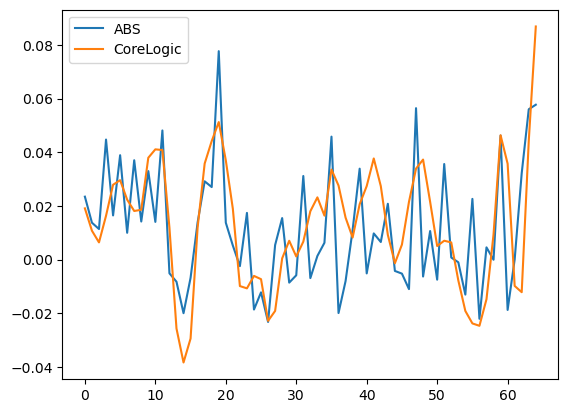

In [19]:
file_path = 'mhp.xlsx'
sheet_name = 'Data1'

# read the file, skipping rows 2-10
df = pd.read_excel(file_path, sheet_name=sheet_name, skiprows=range(1, 10))

cols_to_drop1 = df.filter(regex='Attached').columns
df = df.drop(cols_to_drop1, axis=1)

cols_to_drop2 = df.filter(regex='Number').columns
df1 = df.drop(cols_to_drop2, axis=1)
df2 = df[cols_to_drop2]
df1 = df1.rename(columns={'Unnamed: 0': 'date'})
df1 = df1.set_index('date')
df1.index = df1.index.to_period('Q')

df_log = df1.apply(np.log)
df_diff = df_log.diff()
df_diff = df_diff.dropna()
df_avg_hpig = df_diff.loc['2005Q1':'2021Q1']

df_avg_hpig_mean = df_avg_hpig.mean(axis =1)

import matplotlib.dates as mdates

fig, ax = plt.subplots()
ax.plot(df_avg_hpig.mean(axis=1).values, label='ABS')
ax.plot(df_dis['l0'].values, label='CoreLogic')

ax.legend()


quarters =  df_avg_hpig_mean.index.astype('string')

# ax.set_xticks()
# ax.set_xticklabels(quarters)

# # rotate the tick labels to avoid overlap
# plt.xticks(rotation=45)

# show the plot
plt.show()

In [20]:
# df2.index = df1.index 
# df2 = df2.loc['2005Q1':'2021Q1']

# rowsums = df2.apply(lambda row: row.sum(), axis=1)
# df2_prop = df2.apply(lambda row: row / rowsums.loc[row.name], axis=1)

# df2_prop.columns = range(0,15)
# df_avg_hpig.columns  = range(0,15)
# df_wa = df2_prop * df_avg_hpig

In [21]:
df_l0_new = df_diff.loc['2005Q1':'2023Q1']
df_l0_new_mean = df_l0_new.mean(axis=1)
df_l0_new_mean  = pd.DataFrame(df_l0_new_mean,columns = ['l0'])
df_l0_new_concat = pd.concat([ df_l.loc['2005Q1':'2021Q2']['l0'], df_l0_new_mean.loc['2021Q2':'2023Q1']['l0']])

In [22]:
train_data_nat = pd.concat([df_l0_new_concat, PC_l0],axis = 1)


In [23]:
train_data_nat

,l0,ir,cpi,dvmr,PC1,PC2,PC3,PC4,PC5
date,,,,,,,,,
2005Q1,0.019062,0.015004,0.007335,0.290654,-0.855812,-0.077207,0.018005,-0.209656,0.280150
2005Q2,0.010734,0.031516,0.006072,0.257223,-0.030611,-0.110807,-0.683059,0.073002,0.288315
2005Q3,0.006383,0.000000,0.009639,0.176751,0.198152,0.487517,1.848330,-1.396010,-0.477806
2005Q4,0.016301,0.000000,0.004785,0.198851,-0.033713,-0.121783,-0.220208,-0.485511,-0.133076
2006Q1,0.027860,0.000000,0.008319,0.154151,-0.646364,-0.148937,0.186604,-0.718581,0.928716
...,...,...,...,...,...,...,...,...,...
2021Q4,0.077583,0.000000,0.013278,1.208960,-0.539062,5.343674,2.269669,0.302796,0.774188
2022Q1,0.009236,0.000000,0.021208,1.208960,1.232197,-1.514537,0.003687,-0.214586,-1.845648
2022Q2,0.005746,1.352393,0.017600,1.222795,-0.078847,0.323569,-0.863801,0.161601,0.165532


In [24]:
# selected_columns = [0,1,3,4,5,7,8]

selected_columns = [0,1,2,4,5,7,8]

train_data =train_data_nat.iloc[- 4*16:,selected_columns]

#
model = VAR(train_data)
VAR_nat = model.fit(2)

In [25]:
VAR_nat.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 09, Apr, 2023
Time:                     20:06:27
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                   -20.0577
Nobs:                     62.0000    HQIC:                  -22.2457
Log likelihood:           222.644    FPE:                5.67939e-11
AIC:                     -23.6601    Det(Omega_mle):     1.24626e-11
--------------------------------------------------------------------
Results for equation l0
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const          0.008505         0.005192            1.638           0.101
L1.l0          0.971325         0.172628            5.627           0.000
L1.ir         -0.002833         0.013686           -0.207           0.836
L1.cpi         0.

In [26]:
VARnat_residuals = VAR_nat.resid

mat_nat = train_data_nat.values
 
from scipy.stats import normaltest
normaltest_results = normaltest(VARnat_residuals )
print('Normal test statistics: ', normaltest_results.statistic)
print('Normal test p-value: ', normaltest_results.pvalue)

Normal test statistics:  [ 5.47380355 24.85664288 20.94117935 13.6148335  26.93903451  3.45858971
 24.06672953]
Normal test p-value:  [6.47707107e-02 4.00358063e-06 2.83583319e-05 1.10554511e-03
 1.41339315e-06 1.77409465e-01 5.94259431e-06]


<Axes: >

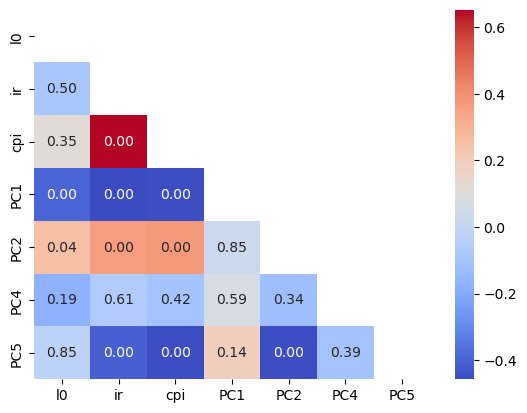

In [27]:
# Extract the residuals from the fitted model
residuals = VARnat_residuals

# Compute the correlation matrix of residuals
corr_matrix = residuals.corr()

# Calculate the p-values for each correlation coefficient in the matrix
from scipy.stats import pearsonr

p_values = []
for i in range(corr_matrix.shape[0]):
    row_p_values = []
    for j in range(corr_matrix.shape[1]):
        if i == j:
            row_p_values.append(1.0)
        else:
            corr_coeff, p_value = pearsonr(residuals.iloc[:, i], residuals.iloc[:, j])
            row_p_values.append(p_value)
    p_values.append(row_p_values)

# Create a heatmap of the correlation matrix with the p-values overlaid on each cell
import seaborn as sns
import numpy as np

# Mask the upper triangle of the correlation matrix to show only the lower triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Create the heatmap with the p-values overlaid on each cell
sns.heatmap(corr_matrix, annot=p_values, fmt=".2f", mask=mask, cmap="coolwarm")

In [28]:
# from statsmodels.tsa.statespace.varmax import VARMAX,VARMAXResults
# model = VARMAX(train_data, order=(1,0), trend='c') 
# results = model.fit(maxiter=1000, disp=False)
# results.summary()

In [29]:


# # Load your data into a pandas DataFrame
# data = train_data

# # Define a range of lag orders to consider
# max_lag = 10
# lag_order_range = range(1, max_lag + 1)

# # Initialize variables to store AIC and BIC values for each lag order
# aic_values = []
# bic_values = []

# # Iterate over each lag order
# for lag_order in lag_order_range:
#     # Create a VAR model with the current lag order
#     model = VAR(data)
#     results = model.fit(lag_order)

#     # Append AIC and BIC values to the lists
#     aic_values.append(results.aic)
#     bic_values.append(results.bic)

# # Determine the lag order with the lowest AIC and BIC values
# best_aic_order = aic_values.index(min(aic_values)) + 1
# best_bic_order = bic_values.index(min(bic_values)) + 1

# # Fit the final VAR models with the best lag orders
# best_aic_model = VAR(data).fit(best_aic_order)
# best_bic_model = VAR(data).fit(best_bic_order)

# # Print the chosen lag orders and the final model summaries
# # print(f"Best AIC lag order: {best_aic_order}")
# # print(best_aic_model.summary())

# # print(f"Best BIC lag order: {best_bic_order}")
# # print(best_bic_model.summary())

# # # Make forecasts using the best models
# # forecast_aic = best_aic_model.forecast(data.values[-best_aic_order:], steps=5)
# # forecast_bic = best_bic_model.forecast(data.values[-best_bic_order:], steps=5)
# # print(f"Forecast using AIC-selected model: {forecast_aic}")
# # print(f"Forecast using BIC-selected model: {forecast_bic}")


In [30]:
data_LTSM = train_data_nat.iloc[:,[0,1,2,3,4,5,6,7,8]]
len(data_LTSM.columns)

9

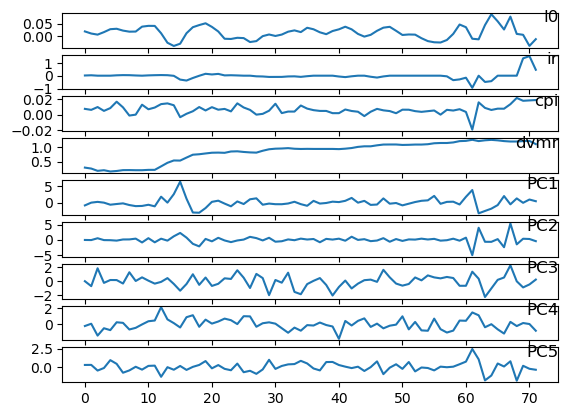

In [31]:
from matplotlib import pyplot
i  = 1
pyplot.figure()
for col in data_LTSM.columns:
     pyplot.subplot(len(data_LTSM.columns), 1, i)
     pyplot.plot(data_LTSM[col].values)
     pyplot.title(col, y=0.5, loc='right')
     i  =  i+1
pyplot.show()


In [32]:
data_LTSM

,l0,ir,cpi,dvmr,PC1,PC2,PC3,PC4,PC5
date,,,,,,,,,
2005Q1,0.019062,0.015004,0.007335,0.290654,-0.855812,-0.077207,0.018005,-0.209656,0.280150
2005Q2,0.010734,0.031516,0.006072,0.257223,-0.030611,-0.110807,-0.683059,0.073002,0.288315
2005Q3,0.006383,0.000000,0.009639,0.176751,0.198152,0.487517,1.848330,-1.396010,-0.477806
2005Q4,0.016301,0.000000,0.004785,0.198851,-0.033713,-0.121783,-0.220208,-0.485511,-0.133076
2006Q1,0.027860,0.000000,0.008319,0.154151,-0.646364,-0.148937,0.186604,-0.718581,0.928716
...,...,...,...,...,...,...,...,...,...
2021Q4,0.077583,0.000000,0.013278,1.208960,-0.539062,5.343674,2.269669,0.302796,0.774188
2022Q1,0.009236,0.000000,0.021208,1.208960,1.232197,-1.514537,0.003687,-0.214586,-1.845648
2022Q2,0.005746,1.352393,0.017600,1.222795,-0.078847,0.323569,-0.863801,0.161601,0.165532


In [33]:
data = data_LTSM
columns_to_shift = ['l0', 'ir','cpi', 'PC1', 'PC2','PC4', 'PC5'] 
columns_to_drop = ['l0', 'ir','cpi', 'PC1', 'PC2','PC3' ,'PC4', 'PC5']

shifted_1 = data[columns_to_shift].shift(1)
shifted_1.columns = [f"{col}_t-1" for col in columns_to_shift]

shifted_2 = data[columns_to_shift].shift(2)
shifted_2.columns = [f"{col}_t-2" for col in columns_to_shift]

new_data = pd.concat([data, shifted_1,shifted_2], axis=1)
# Drop rows with missing values due to shifting
new_data.dropna(inplace=True)

new_data_shifted = new_data.drop(columns_to_drop, axis=1)


values = new_data_shifted.values
scaler_LTSM = MinMaxScaler(feature_range=(0, 1))
scaled_values = scaler_LTSM.fit_transform(values)


n_train_quaters = 4 * 15 
train = scaled_values [:n_train_quaters, :]
test = scaled_values [n_train_quaters:, :]
# split into input and outputs
train_X, train_y = train[:, 1:], train[:, 0]
test_X, test_y = test[:, 1:], test[:, 0]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(60, 1, 14) (60,) (10, 1, 14) (10,)


In [34]:
new_data_shifted

,dvmr,l0_t-1,ir_t-1,cpi_t-1,PC1_t-1,PC2_t-1,PC4_t-1,PC5_t-1,l0_t-2,ir_t-2,cpi_t-2,PC1_t-2,PC2_t-2,PC4_t-2,PC5_t-2
date,,,,,,,,,,,,,,,
2005Q3,0.176751,0.010734,0.031516,0.006072,-0.030611,-0.110807,0.073002,0.288315,0.019062,0.015004,0.007335,-0.855812,-0.077207,-0.209656,0.280150
2005Q4,0.198851,0.006383,0.000000,0.009639,0.198152,0.487517,-1.396010,-0.477806,0.010734,0.031516,0.006072,-0.030611,-0.110807,0.073002,0.288315
2006Q1,0.154151,0.016301,0.000000,0.004785,-0.033713,-0.121783,-0.485511,-0.133076,0.006383,0.000000,0.009639,0.198152,0.487517,-1.396010,-0.477806
2006Q2,0.171637,0.027860,0.000000,0.008319,-0.646364,-0.148937,-0.718581,0.928716,0.016301,0.000000,0.004785,-0.033713,-0.121783,-0.485511,-0.133076
2006Q3,0.201816,0.029573,0.028573,0.016432,-0.437986,-0.290396,0.254086,0.428339,0.027860,0.000000,0.008319,-0.646364,-0.148937,-0.718581,0.928716
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021Q4,1.208960,0.026631,0.000000,0.007547,1.930575,-2.462536,-1.144938,0.070838,0.058932,0.000000,0.007605,-0.758322,0.204275,-0.620065,0.476164
2022Q1,1.208960,0.077583,0.000000,0.013278,-0.539062,5.343674,0.302796,0.774188,0.026631,0.000000,0.007547,1.930575,-2.462536,-1.144938,0.070838
2022Q2,1.222795,0.009236,0.000000,0.021208,1.232197,-1.514537,-0.214586,-1.845648,0.077583,0.000000,0.013278,-0.539062,5.343674,0.302796,0.774188


Epoch 1/100


2023-04-09 20:06:28.910407: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


15/15 - 1s - loss: 0.4942 - val_loss: 0.6967 - 1s/epoch - 74ms/step
Epoch 2/100
15/15 - 0s - loss: 0.3520 - val_loss: 0.4945 - 31ms/epoch - 2ms/step
Epoch 3/100
15/15 - 0s - loss: 0.2568 - val_loss: 0.2992 - 31ms/epoch - 2ms/step
Epoch 4/100
15/15 - 0s - loss: 0.2229 - val_loss: 0.2044 - 32ms/epoch - 2ms/step
Epoch 5/100
15/15 - 0s - loss: 0.2470 - val_loss: 0.2085 - 32ms/epoch - 2ms/step
Epoch 6/100
15/15 - 0s - loss: 0.2475 - val_loss: 0.2297 - 34ms/epoch - 2ms/step
Epoch 7/100
15/15 - 0s - loss: 0.2369 - val_loss: 0.2163 - 32ms/epoch - 2ms/step
Epoch 8/100
15/15 - 0s - loss: 0.2424 - val_loss: 0.2228 - 30ms/epoch - 2ms/step
Epoch 9/100
15/15 - 0s - loss: 0.2394 - val_loss: 0.2251 - 30ms/epoch - 2ms/step
Epoch 10/100
15/15 - 0s - loss: 0.2394 - val_loss: 0.2288 - 31ms/epoch - 2ms/step
Epoch 11/100
15/15 - 0s - loss: 0.2353 - val_loss: 0.2193 - 30ms/epoch - 2ms/step
Epoch 12/100
15/15 - 0s - loss: 0.2412 - val_loss: 0.2291 - 29ms/epoch - 2ms/step
Epoch 13/100
15/15 - 0s - loss: 0.2363

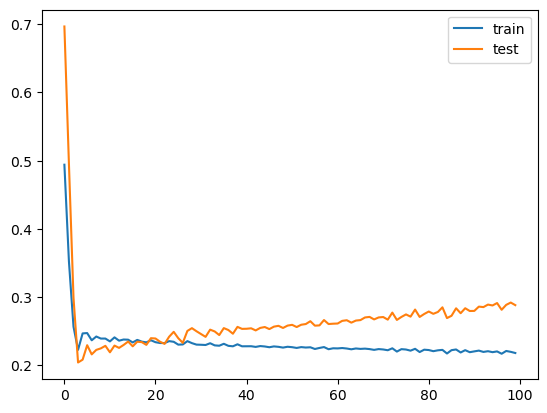

In [35]:
from keras.models import Sequential
LTSM_model = Sequential()
LTSM_model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
LTSM_model.add(Dense(1))
LTSM_model.compile(loss='mae', optimizer='adam')
# fit network
history = LTSM_model.fit(train_X, train_y, epochs=100, batch_size=4, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [36]:
# for col in train_data.columns:
#     if col != 'dvmr':
#         VAR_nat.params.loc['L1.dvmr',col] = 0
        
# dvmr_coef = VAR_nat.params['dvmr']
# dvmr_pvals = VAR_nat.pvalues['dvmr']
# for i in range(len(dvmr_coef)):
#     if dvmr_pvals[i] > 0.05:
#         dvmr_coef[i] = 0
# VAR_nat.params['dvmr_L1'] = dvmr_coef


In [37]:
# p_threshold = 0.05
# for i in range(len(VAR_nat.params)):
#     for j in range(len(VAR_nat.params[i])):
#         if VAR_nat.pvalues[i][j] > p_threshold:
#             VAR_nat.params[i][j] = 0

In [38]:
# df_emp = pd.DataFrame(VAR_nat.resid)
# u = pseudo_obs(df_emp)
# emp_cop = EmpiricalCopula(u, smoothing='beta')
# df_vol_nat = EmpiricalCopula.to_marginals(emp_cop.random(10000, seed=1), df_emp)


# top100 = df_vol_nat.iloc[:, 1].nlargest(0).index
# bottom100 = df_vol_nat.iloc[:, 1].nsmallest(0).index

# # drop rows with these indices
# df_vol_nat_new = df_vol_nat.drop(top100.union(bottom100)).reset_index(drop = True)




In [39]:
# # print the resulting dataframe
# sns.histplot(df_vol_nat_new.iloc[:,1])

In [40]:
mat_l2 =(df_l.values)[:,1: ]
X = mat_nat[- 4*16:,selected_columns[1:]]

Dict_reg = {}
pc_index = 0 

for pc in avg_3_pivot.columns:  
    Y = mat_l2[- 4*16:,pc_index]
    pc_index = pc_index + 1
    X_train = sm.add_constant(X)
    model_full = sm.OLS(Y,X_train)
    reg_full = model_full.fit()
    Dict_reg[pc] =  reg_full

In [41]:
# def simplified_simulation_lvl1(mat_nat0,mat_l20): 
#     random_int_vol = random.randint(0, 9999)
#     start_period = - 4*16
#     train_data =mat_nat0[start_period:,:]
#     results = VAR_nat
#     X_test = results.forecast(train_data[-1:], steps=1)
# #     predicted_l0 = X_test[0][0]
    
#     mat_pc_nat = mat_nat0[start_period:,1:]

#     onesteppres = []
#     pc_index = 0 
#     for pc in avg_3_pivot.columns:
# #       arr_l2 = (df_l[pc].values)[start_period:]
# #         Y =mat_l2[start_period:,pc_index]
#         pc_index = pc_index + 1

# #         X_train = sm.add_constant(X)
# #         model_full = sm.OLS(Y,X_train)
# #         reg_full = model_full.fit()
#         reg_full = Dict_reg[pc] 
#         predicted_l2 = reg_full.predict(X_test) 
#         onesteppre =  predicted_l0 + predicted_l2[0] + df_vol.loc[random_int_vol][pc] 
#         onesteppres.append(onesteppre)
   
#     idx = np.abs(df_vol_nat.iloc[:,0] -  df_vol.loc[random_int_vol].mean()).argmin()
# # Extract the whole row
#     closest_row =   df_vol_nat.iloc[idx]
#     new_nat_rf = X_test[0] + closest_row.values
#     return new_nat_rf, onesteppres

In [42]:
def simplified_simulation_lvl1(mat_nat0,mat_l20): 
    random_int_vol = random.randint(0, 9999)
    start_period = - 4*16
    train_data = mat_nat0[start_period:,:]
##    
#     model = VAR(train_data)
#     results = model.fit(1)
    results = VAR_nat
#     X_test = results.forecast(train_data.values[-1:], steps=1)

    X_test = results.forecast(train_data[-3:], steps=1)
    predicted_l0 = X_test[0][0]
    
    mat_pc_nat = mat_nat0[start_period:,1:]

    onesteppres = []
    pc_index = 0 
    for pc in avg_3_pivot.columns:      
#       arr_l2 = (df_l[pc].values)[start_period:]
#       
#         X = mat_pc_nat 
#         Y = mat_l20[start_period:,pc_index]    
        pc_index = pc_index + 1       
#         X_train = sm.add_constant(X)
#         model_full = sm.OLS(Y,X_train)
#         reg_full = model_full.fit()    
        reg_full = Dict_reg[pc] 
        predicted_l2 = reg_full.predict(np.insert(X_test[0][1:],0,1)) 
#        onesteppre =  predicted_l0 + predicted_l2[0] + df_vol.loc[random_int_vol][pc] 
        onesteppre =  predicted_l0 + predicted_l2[0] 
        onesteppres.append(onesteppre)
#     idx = np.abs(df_vol_nat.iloc[:,0] -  df_vol.loc[random_int_vol].mean()).argmin()
# Extract the whole row
#     closest_row =   df_vol_nat.iloc[idx]
#   new_nat_rf = X_test[0] + df_vol_nat.iloc[random_int_vol]
    new_nat_rf = X_test[0]
    return new_nat_rf, onesteppres

In [62]:
def simplified_simulation_lvl2(train_data_nat,df_l):
    mat_nat_ = train_data_nat.values[- 4*16:,:].copy()
    mat_l2_ =(df_l.values)[- 4*16:,1: ].copy()
    sim_step = 0
    #extend the years of prediction 
    while sim_step < 4*55:
        sim_step =  sim_step +1 
        new_nat_rf_, onesteppres_ = simplified_simulation_lvl1(mat_nat_,mat_l2_)
        mat_nat_ = np.vstack([mat_nat_, new_nat_rf_])
        mat_l2_ = np.vstack([mat_l2_,np.array(onesteppres_)])
    return mat_nat_, mat_l2_

In [63]:
Dict_sim = {}
for i in range(0,1): 
    mat_nat_, mat_l2_ = simplified_simulation_lvl2(train_data_nat.iloc[:,selected_columns],df_l)
    Dict_sim[i] = mat_nat_
    print(i)
    

0


In [64]:
def rates_ori(arr,ini):
    arr_ori = []
    arr_ori.append(ini + arr[0])
    for i in range(1, np.shape(arr)[0]):
        arr_ori.append(arr_ori[i-1]+ arr[i])
    return arr_ori

In [65]:
def rates_ori2(arr,a,b):
    arr_ori = []
    a0 = arr[0] - a + 2*b
    arr_ori.append(a0)
    a1 = arr[1] - b + 2*arr_ori[0]
    arr_ori.append(a1)
    for i in range(2, np.shape(arr)[0]):
        an = arr[i] - arr_ori[i-2] + 2*arr_ori[i-1]
        arr_ori.append(an)
    return np.exp(arr_ori)

In [66]:
narray = Dict_sim[0]
# Extract the first column and name it narr1
narr1 = narray[64:, 0]
# Extract the rest of the array and name it narr2

cumulative_growth = np.exp(np.cumsum(narr1))

house_growth_annual =  np.mean(cumulative_growth.reshape(-1, 4), axis=1)
np.save('house_annual_.npy', house_growth_annual)

In [69]:
ir = narray[64:,1] 
ir_ori_ = np.exp(rates_ori(ir,macvar_log['ir'].values[-1] ))
cpi = narray[64:,2] 
cpi_ori_ = np.exp(rates_ori(cpi,macvar_log['cpi'].values[-1] ))/ np.exp(macvar_log['cpi'].values[-1] )

In [70]:
ir_annual_ = np.mean(ir_ori_.reshape(-1, 4), axis=1)
np.save('ir_annual_.npy', ir_annual_)
print(ir_annual_)
cpi_annual_ = np.mean(cpi_ori_.reshape(-1, 4), axis=1)
np.save('cpi_annual_.npy', cpi_annual_)
print(cpi_annual_)

[3.15785603 4.79942007 4.08202559 3.32779027 3.09175752 3.06178721
 2.91111866 2.7098886  2.5605689  2.43853494 2.3076199  2.17806537
 2.06133244 1.95254984 1.8473997  1.7474395  1.65367564 1.56506381
 1.48090903 1.40125413 1.32599008 1.254771   1.18733867 1.12353175
 1.06316751 1.00604506 0.95198686 0.9008342  0.85243181 0.8066297
 0.76328801 0.72227532 0.68346652 0.64674288 0.61199239 0.57910913
 0.54799276 0.5185483  0.49068593 0.46432065 0.43937202 0.41576392
 0.39342431 0.37228504 0.35228162 0.333353   0.31544146 0.29849232
 0.28245389 0.26727723 0.25291603 0.23932648 0.22646711 0.2142987
 0.20278411]
[1.04612206 1.08098023 1.10447638 1.13403835 1.16614632 1.19768753
 1.22996776 1.26370114 1.29829684 1.33359207 1.3698984  1.40729642
 1.44568577 1.48508023 1.52556364 1.56716749 1.60989822 1.65378742
 1.69887686 1.74519818 1.79278075 1.84165968 1.89187207 1.94345384
 1.99644162 2.05087398 2.10679058 2.16423177 2.22323901 2.28385506
 2.34612382 2.41009033 2.47580085 2.54330295 2.6126

In [72]:
test_X_LTSM1 = narray[63:-1,:] 
test_X_LTSM2 = narray[62:-2,:]
test_X_LTSM =  np.hstack((test_X_LTSM1, test_X_LTSM2))
new_column = np.full((220, 1), 0)  # Create a new array filled with 0.5 of shape (140, 1)
test_X_LTSM_extended = np.hstack((new_column, test_X_LTSM))  # Concatenate the new column and the original array
test_X_LTSM  = scaler_LTSM.transform(test_X_LTSM_extended)[:,1:]

In [73]:
test_X_LTSM = test_X_LTSM.reshape((test_X_LTSM.shape[0], 1, test_X_LTSM.shape[1]))

In [74]:
yhat = LTSM_model.predict(test_X_LTSM )

7/7 [==============================] - 0s 928us/step


In [75]:
test_X_LTSM = test_X_LTSM.reshape((test_X_LTSM .shape[0],test_X_LTSM .shape[2]))

In [76]:
from math import sqrt
from numpy import concatenate

inv_yhat = concatenate((yhat, test_X_LTSM), axis=1)
inv_yhat = scaler_LTSM.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

In [77]:
dvmr = inv_yhat
dvmr_ori_ = np.exp(dvmr) + ir_ori_
dvmr_ori_

array([ 5.01898309,  4.11545303,  4.88081255,  8.09895268, 10.15586655,
        8.2158742 ,  5.81332702,  5.33739598,  6.40978681,  7.54311964,
        7.08726355,  5.79389875,  5.17066459,  5.49703273,  6.20632821,
        6.37444803,  5.84909838,  5.3545903 ,  5.34915635,  5.69692395,
        5.91997107,  5.7428063 ,  5.41263776,  5.27635106,  5.38813156,
        5.53533359,  5.5027843 ,  5.32063084,  5.17821155,  5.17569436,
        5.24472736,  5.25436047,  5.16570287,  5.0576038 ,  5.01196967,
        5.02602267,  5.03421664,  4.9912972 ,  4.9182097 ,  4.8644872 ,
        4.84811223,  4.8435328 ,  4.81828675,  4.76979957,  4.72181703,
        4.69271753,  4.67695822,  4.6562216 ,  4.62194982,  4.58258763,
        4.55067791,  4.52839229,  4.50745228,  4.48031482,  4.44819882,
        4.41786231,  4.39306327,  4.37114833,  4.34730125,  4.32021972,
        4.2927691 ,  4.26796534,  4.24567374,  4.22342998,  4.19960625,
        4.17499117,  4.15140885,  4.12951339,  4.10832901,  4.08

In [78]:
dvmr_annual_ = np.mean(dvmr_ori_.reshape(-1, 4), axis=1)
np.save('dvmr_annual_.npy', dvmr_annual_)

In [79]:
# dvmr = var_nat[:,-1]
# dvmr_ori_ =  np.exp(rates_ori(dvmr,macvar_log['dvmr'].values[-1])) + ir_ori_

# dvmr_ori_

In [80]:
array_gr = []
# Dict_exo_rf = {}

# for i in range(0,100):
#     narray = Dict_sim[i]
#     # Extract the first column and name it narr1
#     narr1 = narray[:, 0]
#     cumulative_growth = np.exp(sum(narr1))-1
#     array_gr.append(cumulative_growth)
    
#     # Extract the rest of the array and name it narr2
#     narr2 = narray[:, 1:]
#     var_nat_processed = pca_nat.inverse_transform(narr2)
#     var_nat = scaler_pca_nat.inverse_transform(var_nat_processed)

In [81]:
Prediction_df = pd.DataFrame({})
Prediction_df["Cash Rates"] = ir_annual_
Prediction_df["Discounted Lending Rates"] = dvmr_annual_
date_range = pd.date_range(start='2023', end='2058',freq = 'A')
Prediction_df.index = date_range
Prediction_df.plot(figsize=(10, 5))
plt.ylim(-0.2, 9.8)
plt.xlabel('Date')
plt.ylabel('Effective Interest Rates (%)')

ValueError: Length mismatch: Expected axis has 55 elements, new values have 35 elements

In [ ]:
date_range 